# Building Dengo Library
In this chapter, we will walk through how to build the C library with the template provided in `dengo.templates`. This is particularly useful when one wants to extend the solver to solve the chemistry alongside hydrodynamical simulations like `enzo`. 

In this example, we will stick with the 2-species primordial chemistry model we used in the last two chapters.

## Generate templates with `ChemicalNetwork.write_solver`
With the `ChemicalNetwork` object, `Dengo` can write the C solver.
The corresponding auxillary library paths are needed to be set as the **environomental variables**, in order to compile our python modules.

- <font color='green'>HDF5_DIR </font>          (HDF5 installation path)
- <font color='green'>CVODE_PATH </font>        (CVode installation path)
- <font color='green'>SUITESPARSE_PATH </font>  (SuiteSparse library which is optional unless we use `KLU` option)
- <font color='green'> DENGO_INSTALL_PATH</font> (Installation Path of Dengo)

`ChemicalNetwork.write_solver` writes serveral files

### Main components that drives `Dengo` C-solver

- <font color='blue'>{{solver_name}}_solver.h </font>
- <font color='blue'>{{solver_name}}_solver.C </font>(major modules in Dengo)
- <font color='blue'>{{solver_name}}_solver_main.h </font>
- <font color='blue'>{{solver_name}}_solver_main.C </font>(example script to use the C library) 
- <font color='blue'>initialize_cvode_solver.C </font>(wrapper function for the CVode library)
- <font color='blue'>Makefile </font>(to compile the dengo library `libdengo.a`)

### Helper function to compile `Dengo` C files for `Python` wrapper
- <font color='blue'>{{solver_name}}_solver_run.pyxbld </font>
- <font color='blue'>{{solver_name}}_solver_run.pyxdep </font>
- <font color='blue'>{{solver_name}}_solver_run.pxd </font>
- <font color='blue'>{{solver_name}}_solver_run.pyx </font> (major Python wrapper)

## Import Libraries and Create the Network

Primordial rates and cooling for the 9-species network are included in the default dengo library in `dengo.primordial_rates` and `dengo.primordial_cooling`. The reactions and cooling are added automatically to the `reaction_registry`, `cooling_registry` and `species_registry` with the call to `dengo.primordial_rates.setup_primordial`.  Here we setup the same sample network we demonstrated in the last chapter with `k01`, `k02` and `reHII`.

In [1]:
import dengo
from dengo.chemical_network import \
 ChemicalNetwork, \
 reaction_registry, \
 cooling_registry, species_registry
import dengo.primordial_rates
import dengo.primordial_cooling

dengo.primordial_rates.setup_primordial()

simpleNetwork = ChemicalNetwork()
simpleNetwork.add_reaction("k01")
simpleNetwork.add_reaction("k02")
simpleNetwork.add_cooling("reHII")
simpleNetwork.init_temperature((1e0, 1e8))

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1


In [2]:
simpleNetwork.write_solver(
    "simple", output_dir = ".", 
    solver_template = "cv_omp/sundials_CVDls", 
    ode_solver_source = "initialize_cvode_solver.C"
)

## Build Cython Module
The solver templates come with a `.pyx` files that lets you build a python interface to the C-library.
In the below we show how the cython module can be built and used.
`{solver_name}_solver_run.run_{solver_name}(init_values, dt, niter)` is the entry point for the built solver.
It takes an dictionary that contains the abundances, and thermal energy, an $dt$, time to advance the fluid parcel, and `niter` the maximum number of iterations as arguments.
It assumes that abundances are in number density with the units of $\rm cm^{-3}$, and thermal energy in $erg/g$. `niter` implicitly sets the initial timestep for the solver, i.e. $df_{solver} = df/ \rm niter$.
Our `cython` module gives the same trajectories as what we had done from scratch with the previous chapters!

In [6]:
import pyximport
import numpy as np
pyximport.install(
    setup_args={"include_dirs":np.get_include()},
    reload_support=True, 
    inplace=True, 
    language_level=3
)

simple_solver_run = pyximport.load_module(
    "simple_solver_run",
    "simple_solver_run.pyx",
    build_inplace = True, 
    pyxbuild_dir = "_dengo_temp", 
    )

You have suitesparse!


/home/kwoksun2/anaconda3/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/gv0/homes/kwoksun2/dengo-merge/cookbook/simple_solver_run.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++


In [10]:
NCELLS = 1
density = 1e-2

init_array = np.ones(NCELLS) * density
init_values = dict()
init_values['H_1']     = init_array 
init_values['H_2']     = init_array 
init_values['de']      = init_array 
init_values['ge']      = np.ones(NCELLS)*1e13

total_density = simpleNetwork.calculate_total_density(init_values)
init_values = simpleNetwork.convert_to_mass_density(init_values)
init_values['de'] = simpleNetwork.calculate_free_electrons(init_values)
init_values['density'] = simpleNetwork.calculate_total_density(init_values)
number_density = simpleNetwork.calculate_number_density(init_values)

rv, rv_int = simple_solver_run.run_simple(init_values, 1e16, niter = 1e5)

Successful iteration[    0]: (1.000e+11) 1.000e+11 / 1.000e+16
End in 97 iterations: 1.00000e+16 / 1.00000e+16 (0.00000e+00)


/tmp/ipykernel_5005/4291065558.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  f.legend(


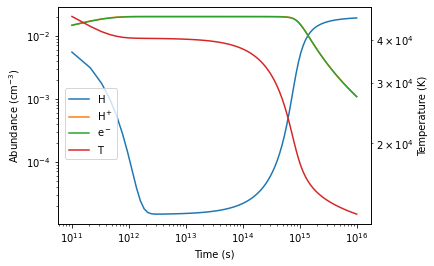

In [11]:
import matplotlib.pyplot as plt
flags = rv_int['t'] > 0
sp_names = [s.name for s in sorted(simpleNetwork.required_species)]
output = np.zeros((len(sp_names),sum(flags)))
                  
for i, s in enumerate(sp_names):
    output[i] = rv_int[s][:,flags]

H_1_traj, H_2_traj, de_traj, ge_traj = output
T_traj    = rv_int['T'][0,flags]
timesteps = rv_int['t'][flags]


f, ax = plt.subplots()
l1= ax.loglog(timesteps, H_1_traj)
l2= ax.loglog(timesteps, H_2_traj)
l3= ax.loglog(timesteps, de_traj)
ax2 = ax.twinx()
l4= ax2.loglog(timesteps, T_traj, color='C3')


ax.set_ylabel(r"Abundance ($\rm cm^{-3}$)")
ax2.set_ylabel("Temperature (K)")

ax.set_xlabel("Time (s)")

f.legend(
    [l1,l2,l3,l4], 
    labels=[r'$\rm H$',r'$\rm H^+$',r'$\rm e^-$',r'$\rm T$'],
    loc=[0.15,0.4]
)
plt.subplots_adjust(right=0.85)

## Main components that drives `Dengo` C-solver

In brief, similar to the example we shown before with the python RHS function, the C templates generate primarily solvers

- <font color='blue'>{{solver_name}}_solver.h </font>
- <font color='blue'>{{solver_name}}_solver.C </font>(major modules in Dengo)
- <font color='blue'>{{solver_name}}_solver_main.h </font>
- <font color='blue'>{{solver_name}}_solver_main.C </font>(example script to use the C library) 
- <font color='blue'>initialize_cvode_solver.C </font>(wrapper function for the CVode library)
- <font color='blue'>Makefile </font>(to compile the dengo library `libdengo.a`)


## `{{solver_name}}_solver_main.C`
An example usage of the built dengo library can be found in the `{{solver_name}}_solver_main.C`. The solver is accessed through 
```C
int simple_solve_chemistry_enzo( code_units *units, dengo_field_data *field_data, double dt );
```
This API follows closely the `Grackle` solver `solver_chemistry` which is tailored to work with `Enzo` simulations. `dengo_field_data` is a data structure that points to the respective abundance pointer `{species.name}_density`. It also informs the setup of the incoming grid. `code_units` informs the dengo solver how to convert from code_units into physical cgs units. `dt` is the delta time the user want to advance the system for. The structure definition taken from `{{solver_name}}_solver.h` are shown below. 
`dengo_field_data.CoolingTime`, `dengo_field_data.MolecularWeight`, `dengo_field_data.temperature`, `dengo_field_data.Gamma`, `dengo_field_data.Pressure` are **not** required inputs. User however needs to allocate space to these pointers if one want Dengo to compute these quantities alongside the chemical evolution. `dengo_data_file` points to the reaction rates `hdf5` data for on-the-fly interpolations.

```C
typedef struct dengo_field_data
{

  unsigned long int nstrip;
  unsigned long int ncells; 
  // let's just pass them passively through field_data
  double reltol;
  double floor_value;
  // This should be updated dynamically 
  // with dengo
  double *density;
  double *H_1_density;
  double *H_2_density;
  double *de_density;
  double *ge_density;
    
  double *CoolingTime;
  double *MolecularWeight;
  double *temperature;
  double *Gamma;
  double *Pressure;

  int *grid_start;
  int *grid_end;
  int *grid_dimension;

  const char *dengo_data_file;
  code_units *units;
} dengo_field_data;

typedef struct code_units
{

  int comoving_coordinates;
  double density_units;
  double length_units;
  double time_units;
  double velocity_units;
  double a_units;
  double a_value;

} code_units;
```

## Build C-library
This template comes with a `Makefile` that lets the user to compile the library. Apart from specifying the `CVODE_PATH`, `SUITESPARSE_PATH`, `DENGO_INSTALL_PATH`, `HDF5_PATH`, there are additional options the user can choose. One can choose either the `CVDLS` which refers to the CVODE dense linear solver, or `CVKLU` which refers to the CVODE KLU Sparse solver. `CVKLU` is oftentimes preferred as it leverages the emptyness in the Jacobian matrix, and utilizes the SuiteSparse library to perform the newton iterations. `DENGO_INSTALL_PATH` is where the library will be installed. 
```
# Use the Dense Linear Solver interface (CVDLS)
#OPTIONS+= -DMAX_NCELLS=1
# Use the Sparse KLU direct solver
OPTIONS = -DCVKLU -DMAX_NCELLS=256
```
The `Make` script uses `libtool` to compile the files and build the libraries. The command `Make` would build and install the libraries. 
Now you have built a `libdengo.so` in your specified installed path, and you are ready to link it to your favorite program with the sample below, or checkout the `Makefile:run_dengo`.

```
$(CC) -o $@ $^ $(OPTIONS) -I$(DENGO_INSTALL_PATH)/include -I$(CVODE_PATH)/include -I$(INCLUDES_KLU) -I$(HDF5_PATH)/include -L$(HDF5_PATH)/lib -lhdf5_hl -lhdf5 -L$(DENGO_INSTALL_PATH)/lib -ldengo -lm
```

## Conclusion
1. We outlie how `ChemicalNetwork.write_solver` works.
2. How to build the cython module from the templates generated.
3. We also outline how the C-library can be built.

In the next chapter, we will outline the procedures needed to link hydrodynamical simulations like `enzo` to `dengo`.